# 自注意力的代码实现

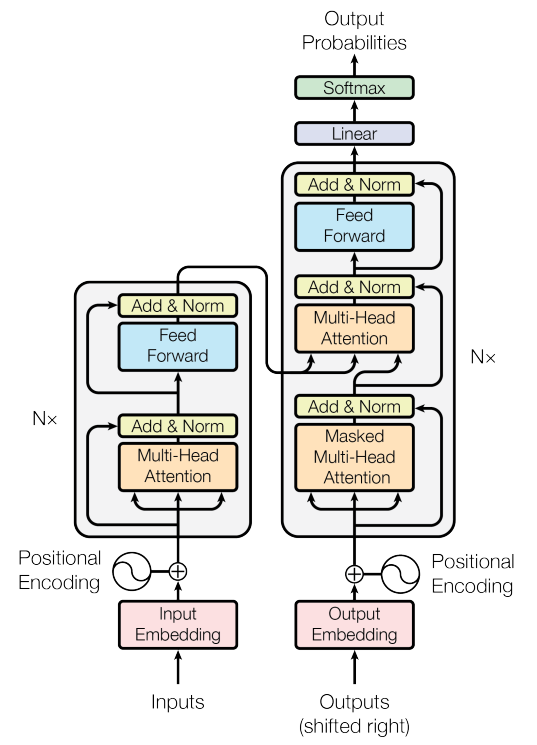

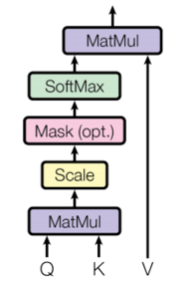

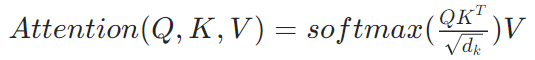

## 对输入句子进行嵌入操作

例句：Life is short, eat dessert first

首先对所给文本建立词典，这里仅考虑例句中的词，实际典型的词典非常大。

In [1]:
sentence = 'Life is short, eat dessert first'

dc = {s:i for i,s 
      in enumerate(sorted(sentence.replace(',', '').split()))}

print(dc)

{'Life': 0, 'dessert': 1, 'eat': 2, 'first': 3, 'is': 4, 'short': 5}


然后基于所建立的词典，对每个词分配整数索引

In [2]:
import torch

sentence_int = torch.tensor(
    [dc[s] for s in sentence.replace(',', '').split()]
)
print(sentence_int)

tensor([0, 4, 5, 2, 1, 3])


对于分配的整数索引，使用一个嵌入层将输入编码为实数向量嵌入

Transformer的论文中base embedding长度为512，这里我们使用3维嵌入，方便复现

In [4]:
vocab_size = 50000

torch.manual_seed(123)
embed = torch.nn.Embedding(vocab_size, 3)
embedded_sentence = embed(sentence_int).detach()

print(embedded_sentence)
print(embedded_sentence.shape)

tensor([[ 0.3374, -0.1778, -0.3035],
        [ 0.1794,  1.8951,  0.4954],
        [ 0.2692, -0.0770, -1.0205],
        [-0.2196, -0.3792,  0.7671],
        [-0.5880,  0.3486,  0.6603],
        [-1.1925,  0.6984, -1.4097]])
torch.Size([6, 3])


## 定义权重矩阵

通过上面的操作，我们获得了输入句子的embedding，接下来是定义自注意力机制中的权重矩阵

自注意力使用了三个权重矩阵： W_q、W_k 和 W_v；其作为模型参数，会在训练过程中不断调整。这些矩阵将输入分别投射成序列的查询、键和值分量，如下图所示：
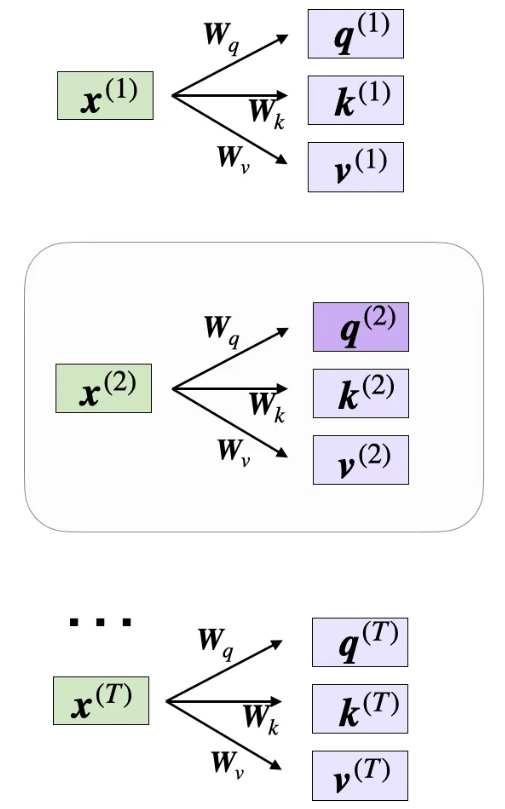

在自注意力中，要计算查询和键向量的点积，因此这两个向量的元素数量必须相同（d_q=d_k）。很多 LLM 也会使用同样大小的值向量，也即 d_q=d_k=d_v。但是，值向量 v⁽ⁱ⁾ 的元素数量可以是任意值，其决定了所得上下文向量的大小。

我们设定d_q=d_k=2，d_v=4。投射矩阵的初始化如下：

In [5]:
torch.manual_seed(123)

d = embedded_sentence.shape[1]

d_q, d_k, d_v = 2, 2, 4

W_query = torch.nn.Parameter(torch.rand(d, d_q))
W_key = torch.nn.Parameter(torch.rand(d, d_k))
W_value = torch.nn.Parameter(torch.rand(d, d_v))

print(W_query)
print(W_key)
print(W_value)

Parameter containing:
tensor([[0.2961, 0.5166],
        [0.2517, 0.6886],
        [0.0740, 0.8665]], requires_grad=True)
Parameter containing:
tensor([[0.1366, 0.1025],
        [0.1841, 0.7264],
        [0.3153, 0.6871]], requires_grad=True)
Parameter containing:
tensor([[0.0756, 0.1966, 0.3164, 0.4017],
        [0.1186, 0.8274, 0.3821, 0.6605],
        [0.8536, 0.5932, 0.6367, 0.9826]], requires_grad=True)


## 计算非归一化的注意力权重

假设我们想为第二个输入元素计算注意力向量 —— 也就是让第二个输入元素作为这里的查询：

In [7]:
x_2 = embedded_sentence[1]
query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value

print(query_2.shape)
print(key_2.shape)
print(value_2.shape)
print(query_2)
print(key_2)
print(value_2)

torch.Size([2])
torch.Size([2])
torch.Size([4])
tensor([0.5667, 1.8269], grad_fn=<SqueezeBackward3>)
tensor([0.5295, 1.7355], grad_fn=<SqueezeBackward3>)
tensor([0.6612, 1.8972, 1.0963, 1.8106], grad_fn=<SqueezeBackward3>)


同理，为所有输入计算剩余的键和值元素，因为下一步计算非归一化注意力权重时会用到它们：

In [8]:
keys = embedded_sentence @ W_key
values = embedded_sentence @ W_value

print("keys.shape:", keys.shape)
print("values.shape:", values.shape)
print(keys)
print(values)

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 4])
tensor([[-0.0823, -0.3031],
        [ 0.5295,  1.7355],
        [-0.2991, -0.7295],
        [ 0.1420,  0.2291],
        [ 0.1920,  0.6467],
        [-0.4788, -0.5835]], grad_fn=<MmBackward0>)
tensor([[-0.2546, -0.2608, -0.1544, -0.2801],
        [ 0.6612,  1.8972,  1.0963,  1.8106],
        [-0.8598, -0.6161, -0.5940, -0.9455],
        [ 0.5932,  0.0981,  0.2741,  0.4151],
        [ 0.5605,  0.5645,  0.3676,  0.6429],
        [-1.2107, -0.4929, -1.0081, -1.4031]], grad_fn=<MmBackward0>)


至此，我们已经拥有了所有必需的键和值，下面就可以计算非归一化注意力权重 ω，如下图所示：
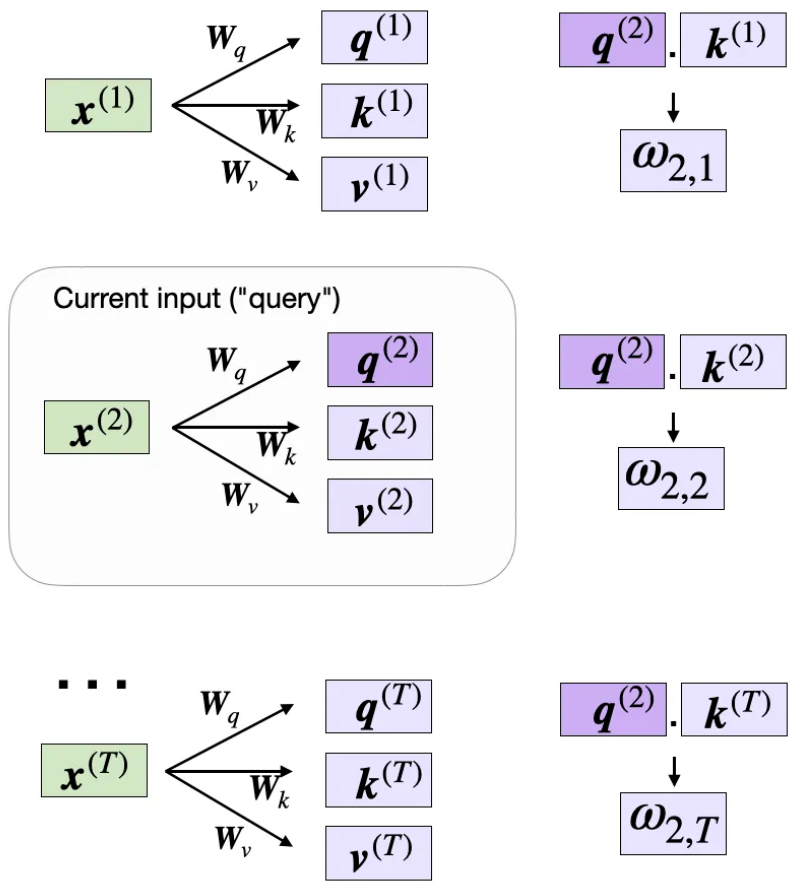

In [11]:
# 例如，我们能以如下方式计算查询与第 5 个输入元素（索引位置为 4）之间的非归一化注意力矩阵：
omega_24 = query_2.dot(keys[4])
print(omega_24)

tensor(1.2903, grad_fn=<DotBackward0>)


In [13]:
# 为所有输入 token 计算 ω 值
omega_2 = query_2 @ keys.T
print(omega_2)

tensor([-0.6004,  3.4707, -1.5023,  0.4991,  1.2903, -1.3374],
       grad_fn=<SqueezeBackward3>)


## 计算注意力权重

自注意力的下一步是将非归一化的注意力权重 ω 归一化，从而得到归一化注意力权重 α（alpha）；这会用到 softmax 函数。此外，在通过 softmax 函数进行归一化之前，还要使用 1/√{d_k} 对 ω 进行缩放，如下所示：
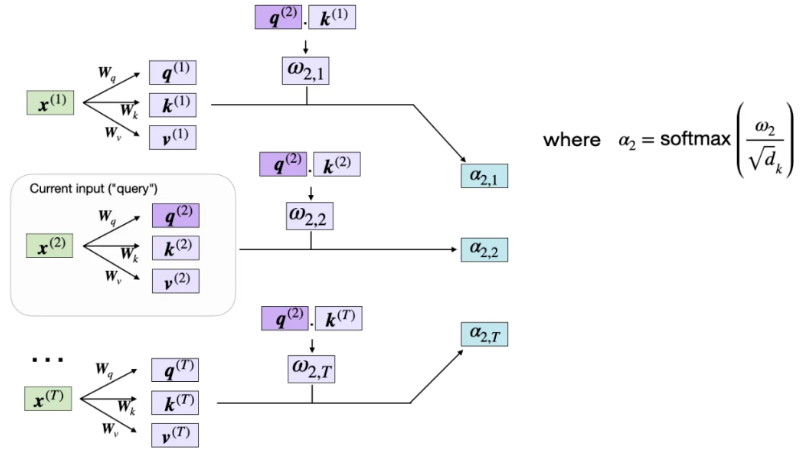

In [14]:
import torch.nn.functional as F

attention_weights_2 = F.softmax(omega_2 / d_k**0.5, dim=0)
print(attention_weights_2)

tensor([0.0386, 0.6870, 0.0204, 0.0840, 0.1470, 0.0229],
       grad_fn=<SoftmaxBackward0>)


最后一步是计算上下文向量 z⁽²⁾，即原始查询输入 x⁽²⁾ 经过注意力加权后的版本，其通过注意力权重将所有其它输入元素作为了上下文：
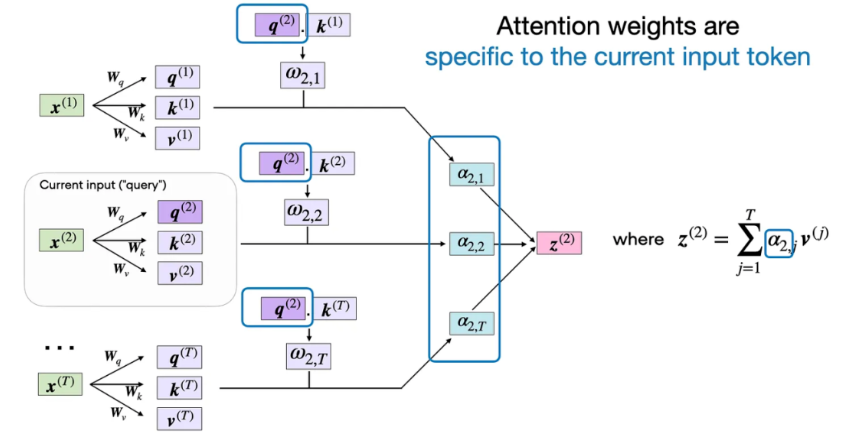

In [15]:
context_vector_2 = attention_weights_2 @ values

print(context_vector_2.shape)
print(context_vector_2)

torch.Size([4])
tensor([0.5313, 1.3607, 0.7891, 1.3110], grad_fn=<SqueezeBackward3>)


## 将上述流程总结为SelfAttention 类

In [18]:
import torch.nn as nn

class SelfAttention(nn.Module):

    def __init__(self, d_in, d_out_kq, d_out_v):
        super().__init__()
        self.d_out_kq = d_out_kq
        self.W_query = nn.Parameter(torch.rand(d_in, d_out_kq))
        self.W_key   = nn.Parameter(torch.rand(d_in, d_out_kq))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out_v))

    def forward(self, x):
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value

        attn_scores = queries @ keys.T  # unnormalized attention weights    
        attn_weights = torch.softmax(
            attn_scores / self.d_out_kq**0.5, dim=-1
        )

        context_vec = attn_weights @ values
        return context_vec

In [19]:
torch.manual_seed(123)

# reduce d_out_v from 4 to 1, because we have 4 heads
d_in, d_out_kq, d_out_v = 3, 2, 4

sa = SelfAttention(d_in, d_out_kq, d_out_v)
print(sa(embedded_sentence))

tensor([[-0.1564,  0.1028, -0.0763, -0.0764],
        [ 0.5313,  1.3607,  0.7891,  1.3110],
        [-0.3542, -0.1234, -0.2626, -0.3706],
        [ 0.0071,  0.3345,  0.0969,  0.1998],
        [ 0.1008,  0.4780,  0.2021,  0.3674],
        [-0.5296, -0.2799, -0.4107, -0.6006]], grad_fn=<MmBackward0>)


# 多头注意力

在缩放点积注意力中，要使用分别表示查询、键和值的三个矩阵来对输入序列执行变换。在讨论多头注意力时，这三个矩阵可被看作是单个注意力头。

多头注意力则涉及到多个这样的头，每一个都由查询、键和值矩阵构成。

代码实现如下：

In [20]:
class MultiHeadAttentionWrapper(nn.Module):

    def __init__(self, d_in, d_out_kq, d_out_v, num_heads):
        super().__init__()
        self.heads = nn.ModuleList(
            [SelfAttention(d_in, d_out_kq, d_out_v) 
             for _ in range(num_heads)]
        )

    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)

In [24]:
# 为了说明简单，我们假设单个 SelfAttention 头的输出维度为 1 。
torch.manual_seed(123)

d_in, d_out_kq, d_out_v = 3, 2, 1

sa = SelfAttention(d_in, d_out_kq, d_out_v)
print(sa(embedded_sentence))

tensor([[-0.0185],
        [ 0.4003],
        [-0.1103],
        [ 0.0668],
        [ 0.1180],
        [-0.1827]], grad_fn=<MmBackward0>)


In [25]:
torch.manual_seed(123)

block_size = embedded_sentence.shape[1]
mha = MultiHeadAttentionWrapper(
    d_in, d_out_kq, d_out_v, num_heads=4
)

context_vecs = mha(embedded_sentence)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[-0.0185,  0.0170,  0.1999, -0.0860],
        [ 0.4003,  1.7137,  1.3981,  1.0497],
        [-0.1103, -0.1609,  0.0079, -0.2416],
        [ 0.0668,  0.3534,  0.2322,  0.1008],
        [ 0.1180,  0.6949,  0.3157,  0.2807],
        [-0.1827, -0.2060, -0.2393, -0.3167]], grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([6, 4])


# 交叉注意力

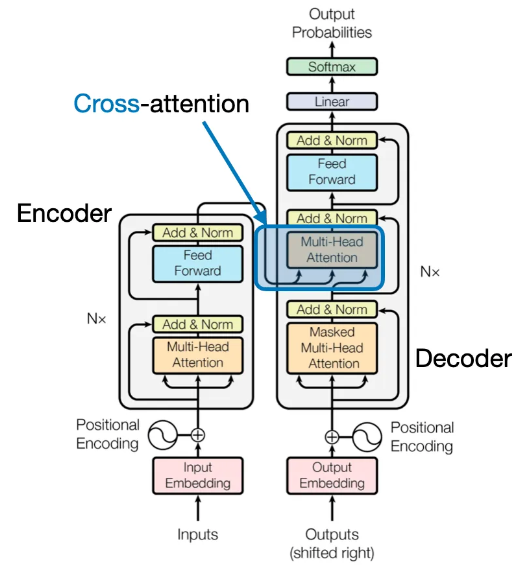
在使用交叉注意力时，两个输入序列 x_1 和 x_2 的元素数量可以不同。但是，它们的嵌入维度必须一样。
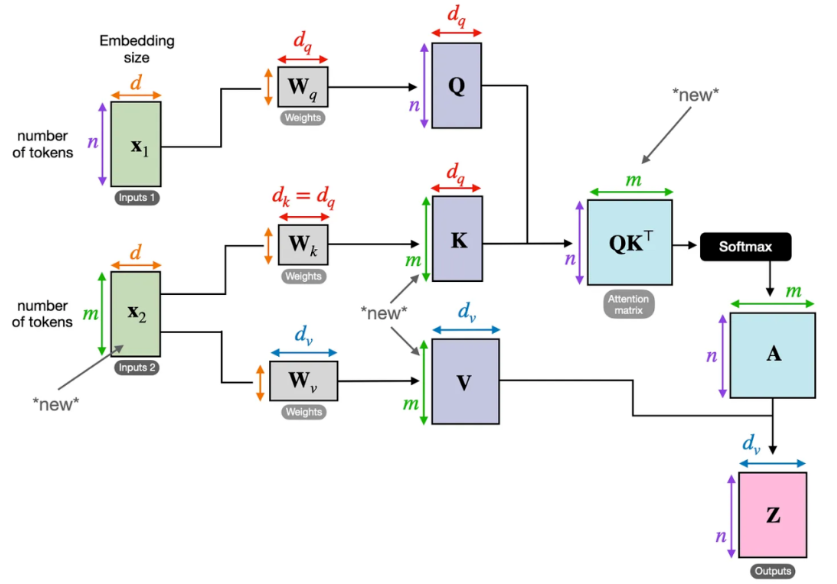

In [26]:
class CrossAttention(nn.Module):

    def __init__(self, d_in, d_out_kq, d_out_v):
        super().__init__()
        self.d_out_kq = d_out_kq
        self.W_query = nn.Parameter(torch.rand(d_in, d_out_kq))
        self.W_key   = nn.Parameter(torch.rand(d_in, d_out_kq))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out_v))

    def forward(self, x_1, x_2):           # x_2 is new
        queries_1 = x_1 @ self.W_query

        keys_2 = x_2 @ self.W_key          # new
        values_2 = x_2 @ self.W_value      # new

        attn_scores = queries_1 @ keys_2.T # new 
        attn_weights = torch.softmax(
            attn_scores / self.d_out_kq**0.5, dim=-1)

        context_vec = attn_weights @ values_2
        return context_vec

In [27]:
torch.manual_seed(123)

d_in, d_out_kq, d_out_v = 3, 2, 4

crossattn = CrossAttention(d_in, d_out_kq, d_out_v)

first_input = embedded_sentence
second_input = torch.rand(8, d_in)

print("First input shape:", first_input.shape)
print("Second input shape:", second_input.shape)

First input shape: torch.Size([6, 3])
Second input shape: torch.Size([8, 3])


In [28]:
context_vectors = crossattn(first_input, second_input)

print(context_vectors)
print("Output shape:", context_vectors.shape)

tensor([[0.4231, 0.8665, 0.6503, 1.0042],
        [0.4874, 0.9718, 0.7359, 1.1353],
        [0.4054, 0.8359, 0.6258, 0.9667],
        [0.4357, 0.8886, 0.6678, 1.0311],
        [0.4429, 0.9006, 0.6775, 1.0460],
        [0.3860, 0.8021, 0.5985, 0.9250]], grad_fn=<MmBackward0>)
Output shape: torch.Size([6, 4])


# 掩码式自注意力（masked self-attention）
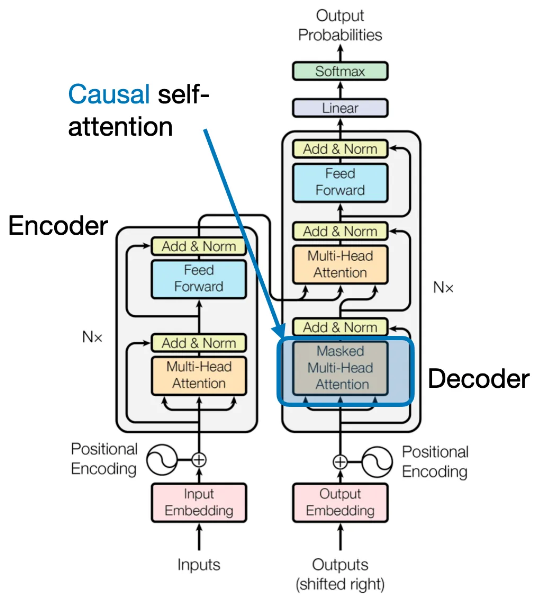

掩码自注意力确保一个序列中某个特定位置的输出仅基于之前位置的已知输出，而不是未来位置的输出。简单来说，它能确保在预测每个新词时只会考虑之前的词。为了在类 GPT 的 LLM 中实现这种机制，对于每个被处理的 token，都要掩盖未来 token，即输入文本中出现在当前 token 之后的 token。
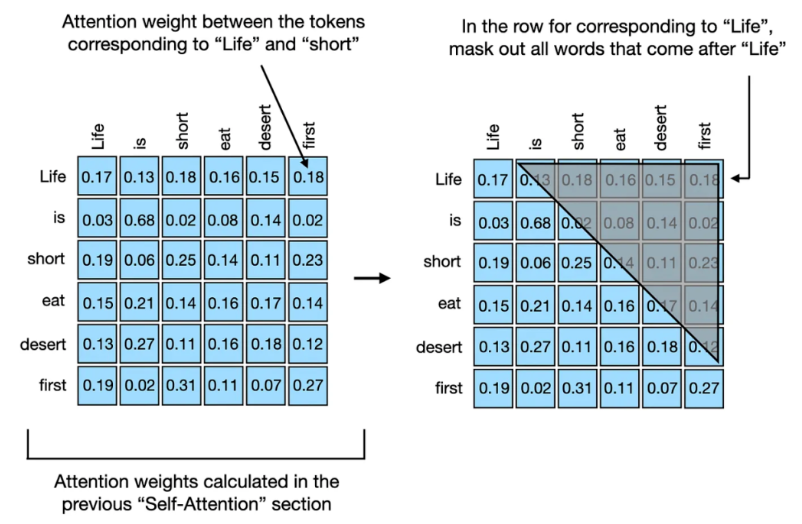

In [29]:
# 首先简单回顾一下之前的注意力分数的计算
torch.manual_seed(123)

d_in, d_out_kq, d_out_v = 3, 2, 4

W_query = nn.Parameter(torch.rand(d_in, d_out_kq))
W_key   = nn.Parameter(torch.rand(d_in, d_out_kq))
W_value = nn.Parameter(torch.rand(d_in, d_out_v))

x = embedded_sentence

keys = x @ W_key
queries = x @ W_query
values = x @ W_value

# attn_scores are the "omegas", 
# the unnormalized attention weights
attn_scores = queries @ keys.T 

print(attn_scores)
print(attn_scores.shape)

tensor([[ 0.0613, -0.3491,  0.1443, -0.0437, -0.1303,  0.1076],
        [-0.6004,  3.4707, -1.5023,  0.4991,  1.2903, -1.3374],
        [ 0.2432, -1.3934,  0.5869, -0.1851, -0.5191,  0.4730],
        [-0.0794,  0.4487, -0.1807,  0.0518,  0.1677, -0.1197],
        [-0.1510,  0.8626, -0.3597,  0.1112,  0.3216, -0.2787],
        [ 0.4344, -2.5037,  1.0740, -0.3509, -0.9315,  0.9265]],
       grad_fn=<MmBackward0>)
torch.Size([6, 6])


In [30]:
# 通过 softmax 函数计算缩放点积注意
attn_weights = torch.softmax(attn_scores / d_out_kq**0.5, dim=1)
print(attn_weights)

tensor([[0.1772, 0.1326, 0.1879, 0.1645, 0.1547, 0.1831],
        [0.0386, 0.6870, 0.0204, 0.0840, 0.1470, 0.0229],
        [0.1965, 0.0618, 0.2506, 0.1452, 0.1146, 0.2312],
        [0.1505, 0.2187, 0.1401, 0.1651, 0.1793, 0.1463],
        [0.1347, 0.2758, 0.1162, 0.1621, 0.1881, 0.1231],
        [0.1973, 0.0247, 0.3102, 0.1132, 0.0751, 0.2794]],
       grad_fn=<SoftmaxBackward0>)


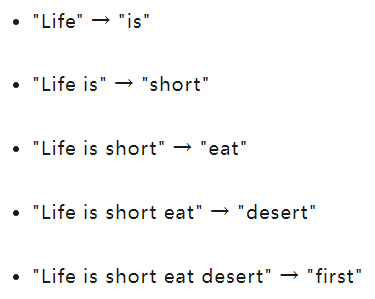
为了实现上述设置，最简单的方法是在注意力权重矩阵的对角线之上使用一个掩码，从而掩蔽掉所有未来 token，如下图所示。
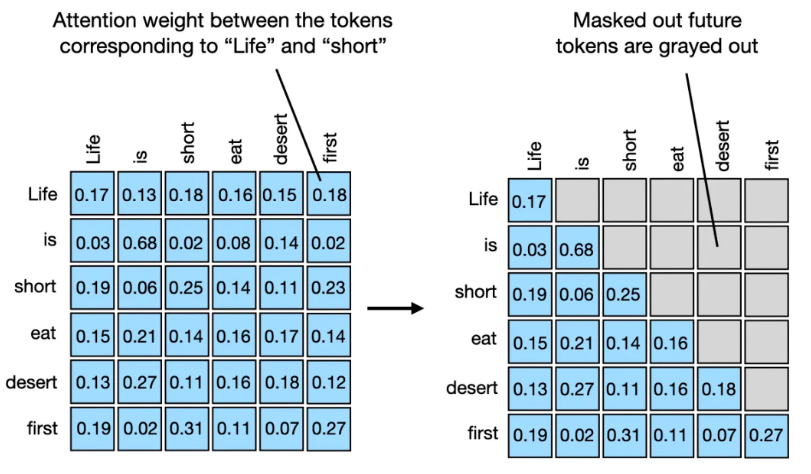

In [32]:
# 在这里可以使用 PyTorch 的 tril 函数，这个函数最初是设计用来创建 1 和 0 的掩码：
block_size = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(block_size, block_size))
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


接下来，将注意力权重与这个掩码相乘，从而将对角线之上的所有注意力权重归零：

In [33]:
masked_simple = attn_weights*mask_simple
print(masked_simple)

tensor([[0.1772, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0386, 0.6870, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1965, 0.0618, 0.2506, 0.0000, 0.0000, 0.0000],
        [0.1505, 0.2187, 0.1401, 0.1651, 0.0000, 0.0000],
        [0.1347, 0.2758, 0.1162, 0.1621, 0.1881, 0.0000],
        [0.1973, 0.0247, 0.3102, 0.1132, 0.0751, 0.2794]],
       grad_fn=<MulBackward0>)


这里需要注意，每一行的注意力权重之和不再是 1 了。为了缓解这一问题，我们可以再次对每行进行归一化，使得它们的和为 1

In [34]:
row_sums = masked_simple.sum(dim=1, keepdim=True)
masked_simple_norm = masked_simple / row_sums
print(masked_simple_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0532, 0.9468, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3862, 0.1214, 0.4924, 0.0000, 0.0000, 0.0000],
        [0.2232, 0.3242, 0.2078, 0.2449, 0.0000, 0.0000],
        [0.1536, 0.3145, 0.1325, 0.1849, 0.2145, 0.0000],
        [0.1973, 0.0247, 0.3102, 0.1132, 0.0751, 0.2794]],
       grad_fn=<DivBackward0>)
